In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

In [2]:
def fit_function(x, A, mu, sigma):
    return (A * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [3]:
def prob_decay(t, half_life=3.052*60.):
    tau = half_life/np.log(2)
    return (1.0-2.0**(-t/tau))

In [4]:
# random seed for reproducibility
np.random.seed(2097494)
# running time in seconds
T = 2500

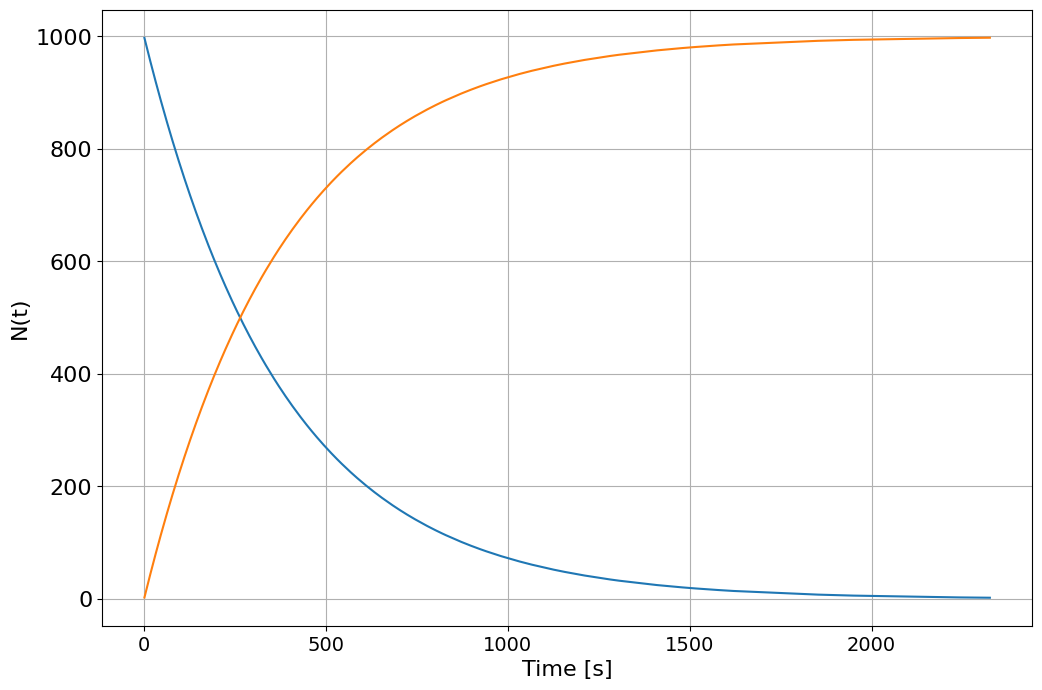

In [5]:
# calculating decays
n_TL_0 = 1000.
n_PB_0 = 0.
# simulating
ts = np.arange(1,T,1)
probs = np.array([prob_decay(t) for t in ts])
rands = np.array([np.random.rand() for _ in ts])
# extracting
decays_mask = (rands >= probs)
decays_PB = (n_TL_0*probs)[decays_mask]
decays_TL = (n_TL_0*np.ones(decays_PB.shape[0]))-decays_PB
t_decays = ts[decays_mask]
# plotting
plt.figure(figsize=(12,8))
plt.plot(t_decays, decays_TL)
plt.plot(t_decays, decays_PB)
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('N(t)', fontsize=16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=16)
plt.grid(axis = 'y')
plt.grid(axis = 'x')        

---

In [6]:
def inverse_func(z, half_life=3.052*60):
    tau = half_life/np.log(2)
    return -1.0*tau*np.log2(1.0-np.random.rand())

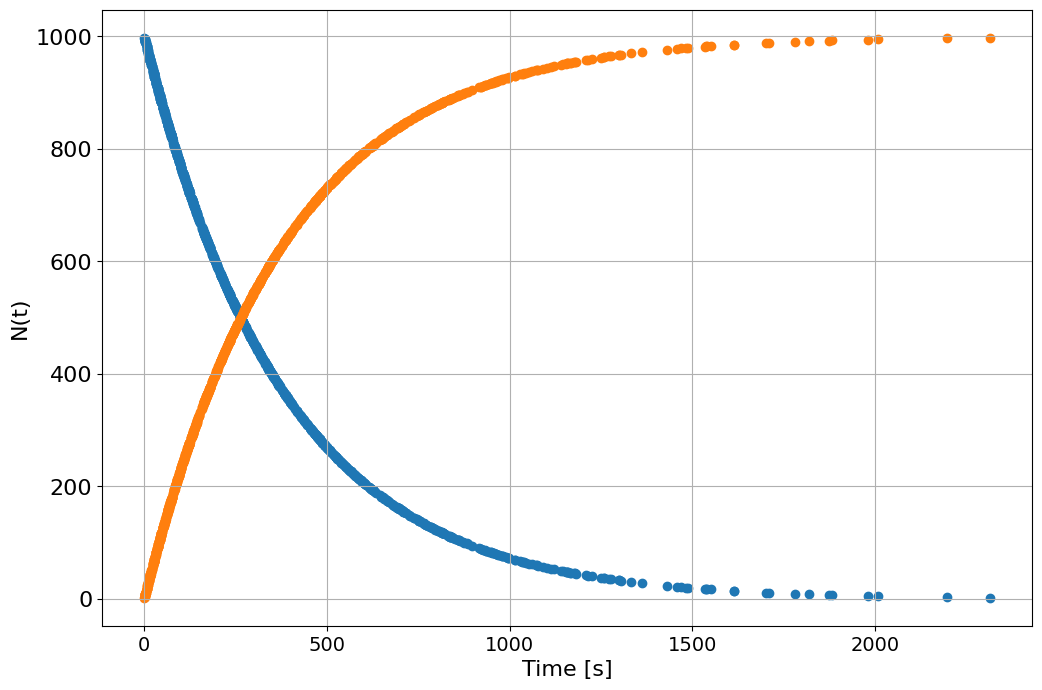

In [7]:
t_decays_sampled = np.array([inverse_func(t) for t in range (1000)])
n_PB = np.array([n_TL_0*prob_decay(t) for t in t_decays_sampled])
n_TL = np.ones(n_PB.shape[0])*n_TL_0 - n_PB
# plotting
plt.figure(figsize=(12,8))
plt.scatter(t_decays_sampled, n_TL)
plt.scatter(t_decays_sampled, n_PB)
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('N(t)', fontsize=16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=16)
plt.grid(axis = 'y')
plt.grid(axis = 'x')   

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [8]:
def tan_theta(b):
    return (79*(1.6*10**(-19))**2)/(2*np.pi*8.85419*10**(-12)*7.7*1.6*10**(-19)*10**6*b)

[0.0166 0.0167 0.0168 0.0168 0.0169 0.0169 0.017  0.0171 0.0171 0.0172
 0.0172 0.0173] (12,)
[ 1.7714e+02  1.6965e-02 -1.3739e-04]


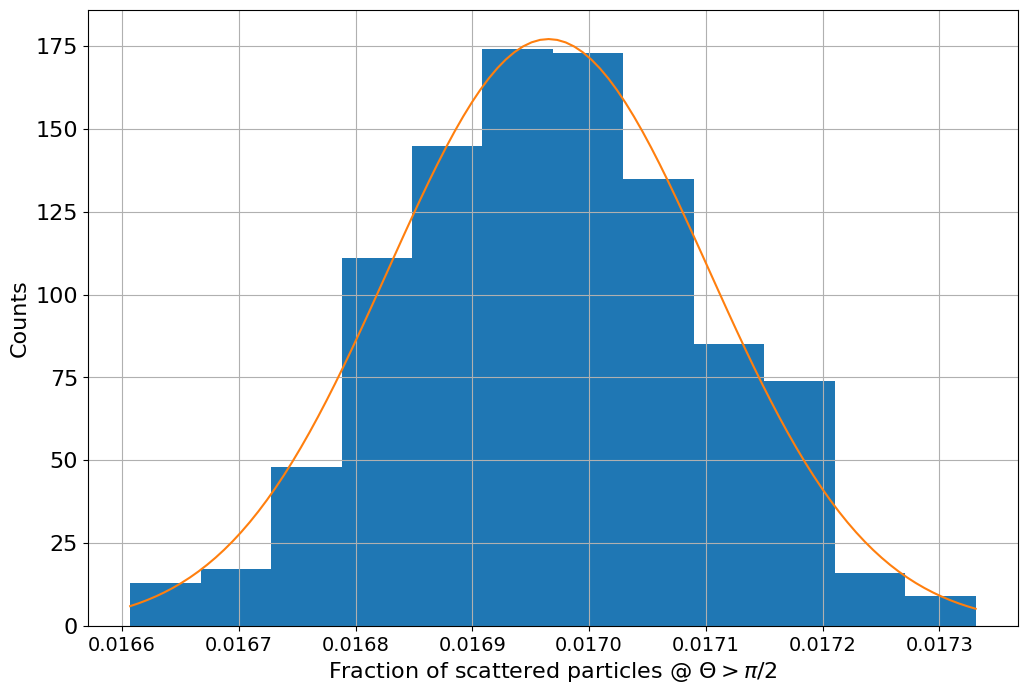

In [9]:
N_particles = 10**6
sim_data = []
for N_sim in range(1000):
    rand_values = np.random.rand(1, N_particles).reshape(-1)
    bs = rand_values*(1.74*10**(-12))
    tt = tan_theta(bs)
    theta = 2.0*np.arctan(tt)
    N_bounce_back = np.sum(theta >= np.pi/2.)
    sim_data.append(N_bounce_back)
sim_data = np.array(sim_data)
sim_frac_data = sim_data / N_particles

# setting up the histrogram bins
bins = np.linspace(np.min(sim_frac_data), np.max(sim_frac_data), 13)
binned_data, actual_bins = np.histogram(sim_frac_data, bins=bins)
bin_centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
print(bin_centers,bin_centers.shape)

# plotting the distribution
plt.figure(figsize=(12,8))
plt.hist(sim_frac_data, bins=bins)
plt.xlabel('Fraction of scattered particles @ $\Theta>\pi/2$', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=16)
plt.grid(axis = 'y')
plt.grid(axis = 'x') 

# curve fit
mean = np.mean(sim_frac_data)
variance = np.var(sim_frac_data)
sigma = np.sqrt(variance)
x_func = np.linspace(np.min(sim_frac_data),np.max(sim_frac_data),100)
popt, pcov = curve_fit(fit_function, bin_centers, binned_data, p0 = [1, mean, sigma])
print(popt)
plt.plot(x_func, fit_function(x_func, *popt))

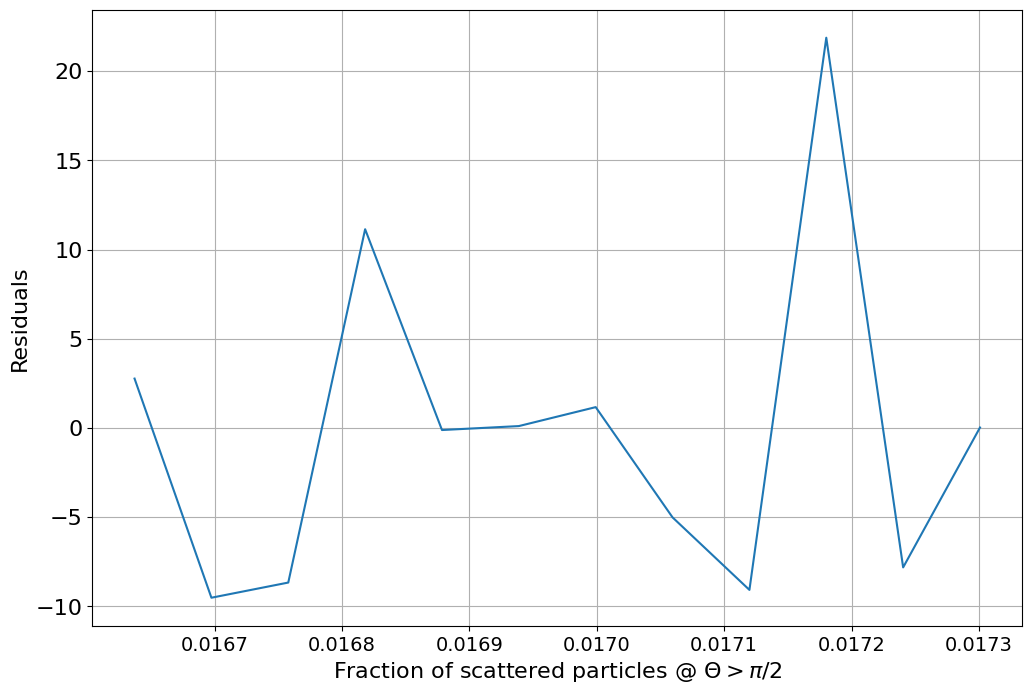

In [10]:
# residuals
residual = np.array([binned_data[i] - fit_function(bin_centers[i], *popt) for i in range(len(bins)-1)])
plt.figure(figsize=(12,8))
#plt.plot(bin_centers, residual)
plt.plot(bin_centers, residual)
plt.xlabel('Fraction of scattered particles @ ${\Theta}>\pi/2$', fontsize=16)
plt.ylabel('Residuals', fontsize=16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=16)
plt.grid(axis = 'y')
plt.grid(axis = 'x')

In [11]:
print("The mean fraction of back-scattered particles at angles >= 90deg is:",np.round(popt[1],4),"+/-",np.round(popt[2],4))

The mean fraction of back-scattered particles at angles >= 90deg is: 0.017 +/- -0.0001


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [12]:
def f(x):
    return np.sin(1./(x*(2.-x)))**2

In [13]:
# hit or miss method
I_values = []
for iteration in range(1000):
    N = 10**4
    hits = 0
    for i in range(N):
        x = np.random.random()*2
        y = np.random.random()
        if y<f(x):
            hits += 1
    I_values.append(2*hits/N)

# getting mean and variance
mean = np.round(np.mean(I_values),4)
sigma = np.round(np.sqrt(np.var(I_values)),4)
print("Integral of f(x) between 0 and 2 is:",mean,"+/-",sigma)

Integral of f(x) between 0 and 2 is: 1.4513 +/- 0.009


---

In [14]:
# mean value method
I_values = []
for iteration in range(100):
    N_pt_xy = 1000
    # generating x between 0 and 2 uniformly
    rand_x = 2*np.random.rand(1,N_pt_xy).flatten()
    # applying the method
    f_vals = [f(rand_x[i]) for i in range(N_pt_xy)]
    integral = 2/N_pt_xy*np.sum(f_vals)
    I_values.append(integral)

# mean and variance
mean = np.round(np.mean(I_values),4)
sigma = np.round(np.var(I_values),4)
print("Integral of f(x) between 0 and 2 is:",mean,"+/-",sigma)

Integral of f(x) between 0 and 2 is: 1.4476 +/- 0.0003


---

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [15]:
def f(x,y):
    if (x**2+y**2)<=1:
        return 1.
    else:
        return 0.  

In [16]:
# mean value method
integrals = []
for iteration in range(1000):
    N_pt_xy = 10000
    # generating x and y points between 0 and 1 uniformly
    rand_x = np.random.rand(1,N_pt_xy).flatten()
    rand_y = np.random.rand(1,N_pt_xy).flatten()
    # applying the method
    f_vals = [f(rand_x[i], rand_y[i]) for i in range(N_pt_xy)]
    integral = 4/N_pt_xy*np.sum(f_vals)
    integrals.append(integral)
# meand and variance
mean = np.round(np.mean(integrals),4)
sigma = np.round(np.sqrt(np.var(integrals)),4)
print("Integral:",mean,"+/-",sigma)

Integral: 3.1418 +/- 0.0157


---

In [17]:
# 10 D sphere
def f10(x_vector):
    val = x_vector.dot(x_vector)
    if val <= 1:
        return 1.
    else:
        return 0.

In [18]:
N_pts = 10**5
integrals = []
for iteration in range(200):
    # generating N_pts random 10-dim vectors to be used as input for f10.
    # they are generated from 0 to 1.
    rand_vector = np.random.rand(N_pts, 10)
    f_vals = np.array([f10(x) for x in rand_vector])
    integral = 2**10/N_pts*np.sum(f_vals)
    integrals.append(integral)
# mean and sigma
mean = np.round(np.mean(integrals),4)
sigma = np.round(np.sqrt(np.var(integrals)),4)
print("Integral in 10D is:",mean,"+/-",sigma)

Integral in 10D is: 2.5694 +/- 0.1694


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [32]:
# i could generate
y = 1.0 / (1.0 + 1.0/stats.expon().rvs(N_pts))
# and then summing between 0 and 1
h_is = 2.0/N_pts*np.sum(y)
# true value and error
h_true = 0.8389
rel_error = np.abs(h_is - h_true)/h_true
print(h_is,",",rel_error)

0.808178329935921 , 0.036621373303229225
